In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from scipy import stats
import re

In [29]:
ruta_carpeta = r"C:\Users\david\Downloads"   # 
archivo = "OLIMPIADAS.csv"
ruta = os.path.join(ruta_carpeta, archivo)
df = pd.read_csv(ruta, encoding="utf-8", sep=None, engine="python")

# Preprocesado

- Marca temporal
- Cálculo de la nota
- Eliminar actuaciones con >5 puntos
- Elimniar actuaciones con <5 votos

In [30]:
# 1️⃣ Limpiar espacios raros y caracteres invisibles
df['Marca temporal'] = df['Marca temporal'].str.replace('\xa0', ' ', regex=False).str.strip()
# 2️⃣ Convertir a formato datetime (detecta la hora y zona)
df['Marca temporal'] = pd.to_datetime(df['Marca temporal'], errors="coerce", utc=True)
# 3️⃣ Quitar zona horaria y quedarte solo con la fecha
df['Marca temporal'] = df['Marca temporal'].dt.tz_convert(None).dt.date
# 4️⃣ (Opcional) Renombrar la columna si quieres quitar las comillas
df = df.rename(columns={'Marca temporal': "fecha"})

C:\Users\david\AppData\Local\Temp\ipykernel_27180\2497915861.py:4: FutureWarning: Parsed string "2024/03/04 5:06:47 p. m. EET" included an un-recognized timezone "EET". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df['Marca temporal'] = pd.to_datetime(df['Marca temporal'], errors="coerce", utc=True)
C:\Users\david\AppData\Local\Temp\ipykernel_27180\2497915861.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Marca temporal'] = pd.to_datetime(df['Marca temporal'], errors="coerce", utc=True)
C:\Users\david\AppData\Local\Temp\ipykernel_27180\2497915861.py:4: FutureWarning: Parsed string "2024/03/04 5:07:16 p. m. EET" included an un-recognized timezone "EET". Dropping unrecognized timezones is deprecate

In [31]:
#Nombres y actuaciones
# --- 1) Limpieza previa de la cadena ---
def _preclean_name(s: str) -> str:
    if pd.isna(s):
        return s
    s = str(s)
    # quitar comillas, backticks y dobles espacios
    s = re.sub(r'["“”\'`]+', '', s).strip()
    s = re.sub(r'\s+', ' ', s)
    # quitar puntos tras iniciales (e.g., "B." -> "B")
    s = re.sub(r'\b([A-Za-z])\.\b', r'\1', s)
    return s

df["Actuante"] = df["Actuante"].apply(_preclean_name)

# --- 2) Diccionario de equivalencias (canónicos a tu gusto) ---
# Nota: elegimos como nombre canónico el de la derecha.
equivalencias = {
    "Sergio G": "Sergio",
    "David B": "David Bestué",
    "Alfredo A": "Alfredo Alvarez",
    "Juan M": "Juan Martinez",
    "Juan Mtnez": "Juan Martinez",
    "Jordi Martí": "Jordi Marti",
    "Jordi Marti": "Jordi Marti",
    "Albert F": "Albert Farriol",
    "Ferran Homar": "Ferran Homar",
    "Ferran H": "Ferran Homar",
    "Alfredo Jauma": "Alfredo Jauma",
    "Alfredo J": "Alfredo Jauma",
    "Lluis": "Lluis Garcia",
    "Amilcar": "Amílcar",
    
}

# Para robustez: mapeo case-insensitive
equiv_ci = {k.casefold(): v for k, v in equivalencias.items()}

def _map_equiv(s: str) -> str:
    if pd.isna(s):
        return s
    return equiv_ci.get(s.casefold(), s)

df["Actuante"] = df["Actuante"].apply(_map_equiv)

# (Opcional) verifica cambios aplicados
antes = set(equivalencias.keys())
despues = set(equivalencias.values())
print("Ejemplos unificados presentes:",
      sorted(set(df["Actuante"]).intersection(despues)))

Ejemplos unificados presentes: ['Albert Farriol', 'Alfredo Alvarez', 'Alfredo Jauma', 'Amílcar', 'David Bestué', 'Ferran Homar', 'Jordi Marti', 'Juan Martinez', 'Lluis Garcia', 'Sergio']


In [32]:
# Asegura que 'fecha' es solo fecha (sin hora) y ordenable
df["fecha"] = pd.to_datetime(df["fecha"], errors="coerce").dt.date

# Guarda el nombre original si quieres conservarlo
df["actuante_original"] = df["Actuante"]

# Ranking de fechas por actuante (1,2,3,...) — mismos días comparten el mismo número
df["n_actuacion"] = (
    df.groupby("Actuante")["fecha"]
      .transform(lambda s: pd.Series(s).rank(method="dense").astype(int))
)

# Renombra: primer día sin sufijo; a partir del segundo, _2, _3, ...
df["Actuante"] = np.where(
    df["n_actuacion"] == 1,
    df["Actuante"],
    df["Actuante"] + "_" + df["n_actuacion"].astype(str)
)

df = df.drop(columns=["n_actuacion"])

In [33]:
def calcular_nota(df: pd.DataFrame) -> pd.DataFrame:
    """
    Añade una columna 'nota' ponderando las cinco preguntas:
      - Imposibilidad del efecto: 30%
      - Presentación y charla: 30%
      - Método: 10%
      - Originalidad: 10%
      - Ejecución: 20%
    La nota resultante queda en la misma escala que las puntuaciones originales (1–10).
    """

    pesos = {
        '¿Qué te ha parecido la imposibilidad del efecto realizado?': 0.30,
        '¿Qué te han parecido la presentación y la charla?': 0.30,
        '¿Qué te ha parecido el método?': 0.10,
        '¿Qué te ha parecido la originalidad del juego?': 0.10,
        '¿Qué te ha parecido la ejecución del juego?': 0.20
    }

    # Asegurar tipo numérico
    for col in pesos.keys():
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Calcular nota ponderada
    df["nota"] = sum(df[col] * peso for col, peso in pesos.items())

    return df

In [34]:
df = calcular_nota(df)
df

,fecha,Actuante,¿Qué te ha parecido la imposibilidad del efecto realizado?,¿Qué te han parecido la presentación y la charla?,¿Qué te ha parecido el método?,¿Qué te ha parecido la originalidad del juego?,¿Qué te ha parecido la ejecución del juego?,actuante_original,nota
0,2024-03-04,Enigma,3,7,3,5,5,Enigma,4.8
1,2024-03-04,Xavi Soler,4,6,1,2,6,Xavi Soler,4.5
2,2024-03-04,Enigma,10,10,10,10,10,Enigma,10.0
3,2024-03-04,Enigma,7,8,7,7,7,Enigma,7.3
4,2024-03-04,Enigma,5,9,5,5,4,Enigma,6.0
...,...,...,...,...,...,...,...,...,...
1546,2025-10-06,Alexander Main_5,2,4,2,2,3,Alexander Main,2.8
1547,2025-10-06,Alexander Main_5,4,5,5,5,5,Alexander Main,4.7
1548,2025-10-06,Alexander Main_5,3,4,4,3,4,Alexander Main,3.6
1549,2025-10-06,Alexander Main_5,4,4,4,4,3,Alexander Main,3.8


C:\Users\david\anaconda3\envs\python3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\david\anaconda3\envs\python3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\david\anaconda3\envs\python3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\david\anaconda3\envs\python3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future

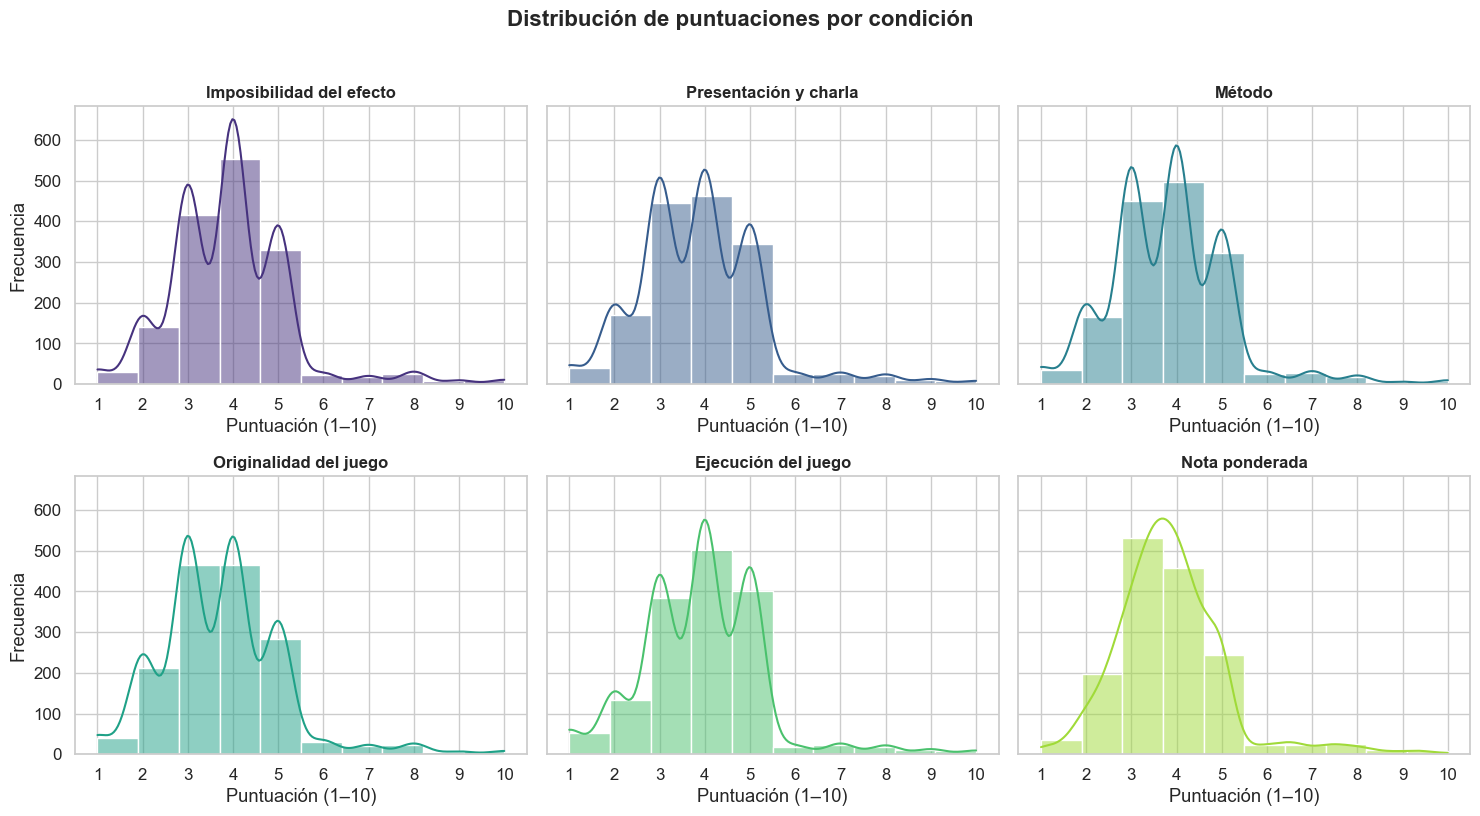

In [35]:
# Columnas de interés
cols = [
    '¿Qué te ha parecido la imposibilidad del efecto realizado?',
    '¿Qué te han parecido la presentación y la charla?',
    '¿Qué te ha parecido el método?',
    '¿Qué te ha parecido la originalidad del juego?',
    '¿Qué te ha parecido la ejecución del juego?',
    'nota'
]

# Nombres más legibles para el título de cada subplot
nombres = [
    'Imposibilidad del efecto',
    'Presentación y charla',
    'Método',
    'Originalidad del juego',
    'Ejecución del juego',
    'Nota ponderada'
]

# Estilo general
sns.set_theme(style="whitegrid", font_scale=1.1)

fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharey=True)
axes = axes.flatten()

for i, col in enumerate(cols):
    sns.histplot(
        df[col].dropna(),
        bins=10,
        kde=True,
        color=sns.color_palette("viridis", 6)[i],
        ax=axes[i]
    )
    axes[i].set_title(nombres[i], fontsize=12, weight="bold")
    axes[i].set_xlim(0.5, 10.5)
    axes[i].set_xticks(range(1, 11))
    axes[i].set_xlabel("Puntuación (1–10)")
    axes[i].set_ylabel("Frecuencia")

plt.suptitle("Distribución de puntuaciones por condición", fontsize=16, weight="bold", y=1.02)
plt.tight_layout()
plt.show()


In [36]:
# Columnas a comprobar (las de puntuaciones + la nota)
cols = [
    '¿Qué te ha parecido la imposibilidad del efecto realizado?',
    '¿Qué te han parecido la presentación y la charla?',
    '¿Qué te ha parecido el método?',
    '¿Qué te ha parecido la originalidad del juego?',
    '¿Qué te ha parecido la ejecución del juego?']

# Convertir a numérico por seguridad
for c in cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# 1️⃣ Encontrar actuantes con alguna puntuación > 5
actuantes_erroneos = df.loc[df[cols].gt(5).any(axis=1), "Actuante"].unique()

print("🔍 Actuantes con valores fuera de rango (eliminados):")
print(actuantes_erroneos)

# 2️⃣ Eliminar todas las filas de esos actuantes
df = df[~df["Actuante"].isin(actuantes_erroneos)].copy()

# 3️⃣ Verificar
print(f"✅ DataFrame limpio: {df.shape[0]} filas restantes.")


🔍 Actuantes con valores fuera de rango (eliminados):
['Enigma' 'Xavi Soler' 'Samu' 'Churrimongui' 'Jaume Cercós'
 'Albert Farriol']
✅ DataFrame limpio: 1436 filas restantes.


C:\Users\david\anaconda3\envs\python3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\david\anaconda3\envs\python3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\david\anaconda3\envs\python3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\david\anaconda3\envs\python3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future

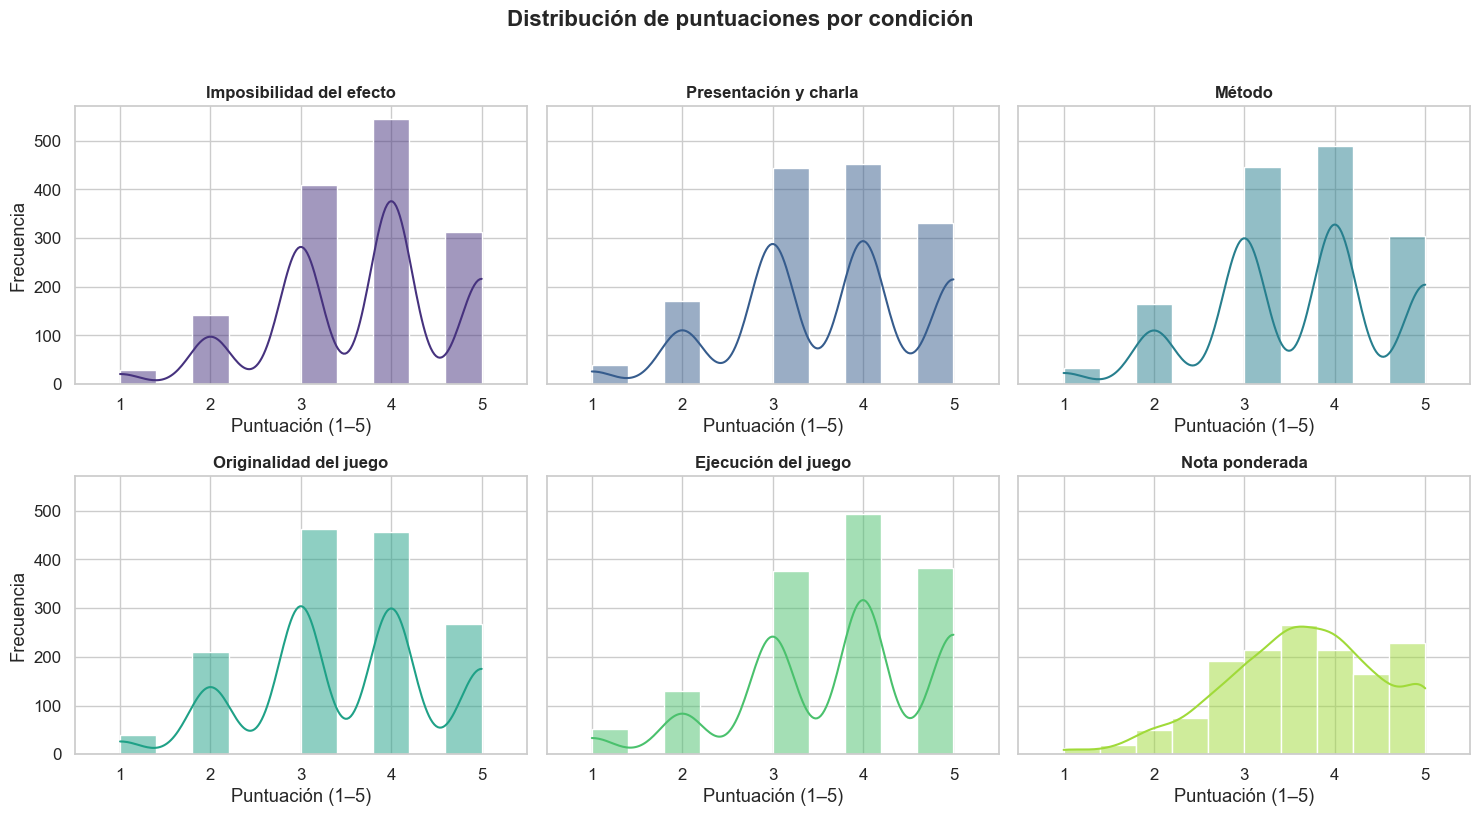

In [37]:
# Columnas de interés
cols = [
    '¿Qué te ha parecido la imposibilidad del efecto realizado?',
    '¿Qué te han parecido la presentación y la charla?',
    '¿Qué te ha parecido el método?',
    '¿Qué te ha parecido la originalidad del juego?',
    '¿Qué te ha parecido la ejecución del juego?',
    'nota'
]

# Nombres más legibles para el título de cada subplot
nombres = [
    'Imposibilidad del efecto',
    'Presentación y charla',
    'Método',
    'Originalidad del juego',
    'Ejecución del juego',
    'Nota ponderada'
]

# Estilo general
sns.set_theme(style="whitegrid", font_scale=1.1)

fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharey=True)
axes = axes.flatten()

for i, col in enumerate(cols):
    sns.histplot(
        df[col].dropna(),
        bins=10,
        kde=True,
        color=sns.color_palette("viridis", 6)[i],
        ax=axes[i]
    )
    axes[i].set_title(nombres[i], fontsize=12, weight="bold")
    axes[i].set_xlim(0.5, 5.5)
    axes[i].set_xticks(range(1, 6))
    axes[i].set_xlabel("Puntuación (1–5)")
    axes[i].set_ylabel("Frecuencia")

plt.suptitle("Distribución de puntuaciones por condición", fontsize=16, weight="bold", y=1.02)
plt.tight_layout()
plt.show()

In [38]:
df["Actuante"] = df["actuante_original"]
df["Actuante"] = df["Actuante"].apply(_preclean_name)
# Asegura que 'fecha' es solo fecha (sin hora) y ordenable
df["fecha"] = pd.to_datetime(df["fecha"], errors="coerce").dt.date
# Ranking de fechas por actuante (1,2,3,...) — mismos días comparten el mismo número
df["n_actuacion"] = (
    df.groupby("Actuante")["fecha"]
      .transform(lambda s: pd.Series(s).rank(method="dense").astype(int))
)

# Renombra: primer día sin sufijo; a partir del segundo, _2, _3, ...
df["Actuante"] = np.where(
    df["n_actuacion"] == 1,
    df["Actuante"],
    df["Actuante"] + "_" + df["n_actuacion"].astype(str)
)

df = df.drop(columns=["n_actuacion"])


In [39]:
#Contar cuántas puntuaciones tiene cada actuación (Actuante con sufijo)
conteos_actuaciones = df["Actuante"].value_counts()

# Identificar las actuaciones con menos de 5 puntuaciones
actuaciones_filtrar = conteos_actuaciones[conteos_actuaciones < 5].index.tolist()

print("🔍 Actuaciones con menos de 5 puntuaciones (se eliminarán):")
print(actuaciones_filtrar)

# (opcional) guardar las actuaciones descartadas
df_descartadas = df[df["Actuante"].isin(actuaciones_filtrar)].copy()

# Filtrar el DataFrame principal
df = df[~df["Actuante"].isin(actuaciones_filtrar)].copy()

print(f"✅ DataFrame limpio: {df['Actuante'].nunique()} actuaciones restantes, {df.shape[0]} filas totales.")

🔍 Actuaciones con menos de 5 puntuaciones (se eliminarán):
['Xavi Soler', 'Jaume Cercós', 'Albert Farriol', 'Manuel Sta Maria', 'Toni Cachadiña_4', 'Shori_3', 'Alexander Main_3', 'David Bestué_3', 'Xavi Soler_3', 'David Valencia_3', 'Jaume Cercós_3']
✅ DataFrame limpio: 89 actuaciones restantes, 1425 filas totales.


In [40]:
df["Actuante"] = df["actuante_original"]
df["Actuante"] = df["Actuante"].apply(_preclean_name)
# Asegura que 'fecha' es solo fecha (sin hora) y ordenable
df["fecha"] = pd.to_datetime(df["fecha"], errors="coerce").dt.date
# Ranking de fechas por actuante (1,2,3,...) — mismos días comparten el mismo número
df["n_actuacion"] = (
    df.groupby("Actuante")["fecha"]
      .transform(lambda s: pd.Series(s).rank(method="dense").astype(int))
)

# Renombra: primer día sin sufijo; a partir del segundo, _2, _3, ...
df["Actuante"] = np.where(
    df["n_actuacion"] == 1,
    df["Actuante"],
    df["Actuante"] + "_" + df["n_actuacion"].astype(str)
)

df = df.drop(columns=["n_actuacion"])

In [41]:
pesos = {
    '¿Qué te ha parecido la imposibilidad del efecto realizado?': 0.30,
    '¿Qué te han parecido la presentación y la charla?': 0.30,
    '¿Qué te ha parecido el método?': 0.10,
    '¿Qué te ha parecido la originalidad del juego?': 0.10,
    '¿Qué te ha parecido la ejecución del juego?': 0.20
}


len(pesos)

5

# Análisis de puntuiacions

C:\Users\david\AppData\Local\Temp\ipykernel_27180\1079872483.py:55: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(


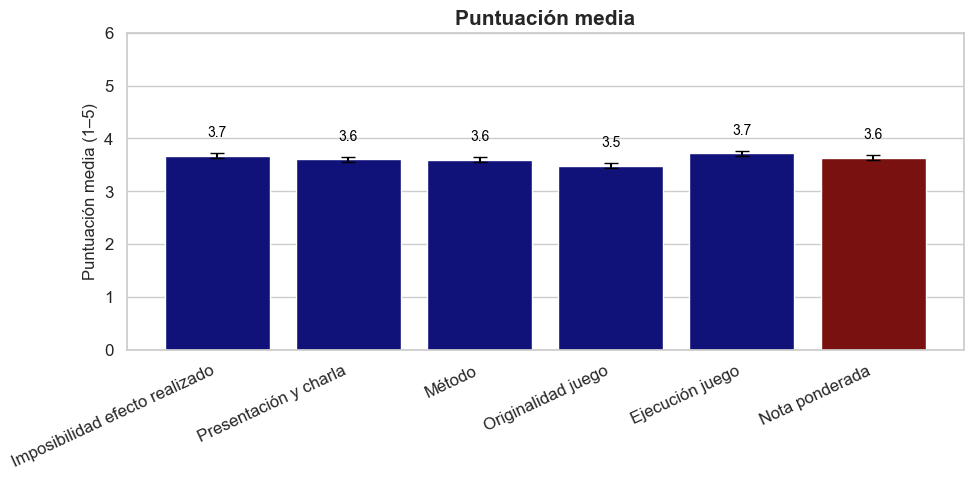

In [42]:
# --- 1. Definir pesos y añadir la columna 'nota' ---
pesos = {
    '¿Qué te ha parecido la imposibilidad del efecto realizado?': 0.30,
    '¿Qué te han parecido la presentación y la charla?': 0.30,
    '¿Qué te ha parecido el método?': 0.10,
    '¿Qué te ha parecido la originalidad del juego?': 0.10,
    '¿Qué te ha parecido la ejecución del juego?': 0.20
}

for col in pesos.keys():
    df[col] = pd.to_numeric(df[col], errors="coerce")

df["nota"] = sum(df[col] * peso for col, peso in pesos.items())

# --- 2. Calcular medias e IC95% para cada condición ---
condiciones = list(pesos.keys()) + ["nota"]
estadisticas = []

for col in condiciones:
    valores = df[col].dropna()
    n = len(valores)
    media = valores.mean()
    sem = stats.sem(valores)
    ci95 = sem * stats.t.ppf((1 + 0.95) / 2., n - 1)
    estadisticas.append({
        "condición": col,
        "media": media,
        "ci95": ci95
    })

df_plot = pd.DataFrame(estadisticas)

# --- 3. Limpiar nombres para el gráfico ---
df_plot["condición"] = (
    df_plot["condición"]
    .str.replace("¿Qué te ha parecido ", "", regex=False)
    .str.replace("¿Qué te han parecido ", "", regex=False)
    .str.replace("del ", "", regex=False)
    .str.replace("la ", "", regex=False)
    .str.replace("el ", "", regex=False)
    .str.replace("?", "", regex=False)
    .str.strip()
    .str.capitalize()
)
df_plot.loc[df_plot["condición"] == "Nota", "condición"] = "Nota ponderada"


colores = ["darkblue" if cond != "Nota ponderada" else "darkred" for cond in df_plot["condición"]]


# --- 4. Plot ---
sns.set_theme(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(10, 5))

ax = sns.barplot(
    data=df_plot,
    x="condición",
    y="media",
    palette=colores,
    ci=None
)

# Añadir barras de error 95%
ax.errorbar(
    x=np.arange(len(df_plot)),
    y=df_plot["media"],
    yerr=df_plot["ci95"],
    fmt="none",
    ecolor="black",
    elinewidth=1.5,
    capsize=5
)

# Añadir texto con las medias
for i, row in df_plot.iterrows():
    ax.text(i, row["media"] + 0.3, f"{row['media']:.1f}",
            ha="center", va="bottom", fontsize=10, color="black")

# Ajustes estéticos
ax.set_title("Puntuación media", fontsize=15, weight="bold")
ax.set_xlabel("", fontsize=12)
ax.set_ylabel("Puntuación media (1–5)", fontsize=12)
ax.set_ylim(0, 6)
plt.xticks(rotation=25, ha="right")
plt.tight_layout()
plt.show()


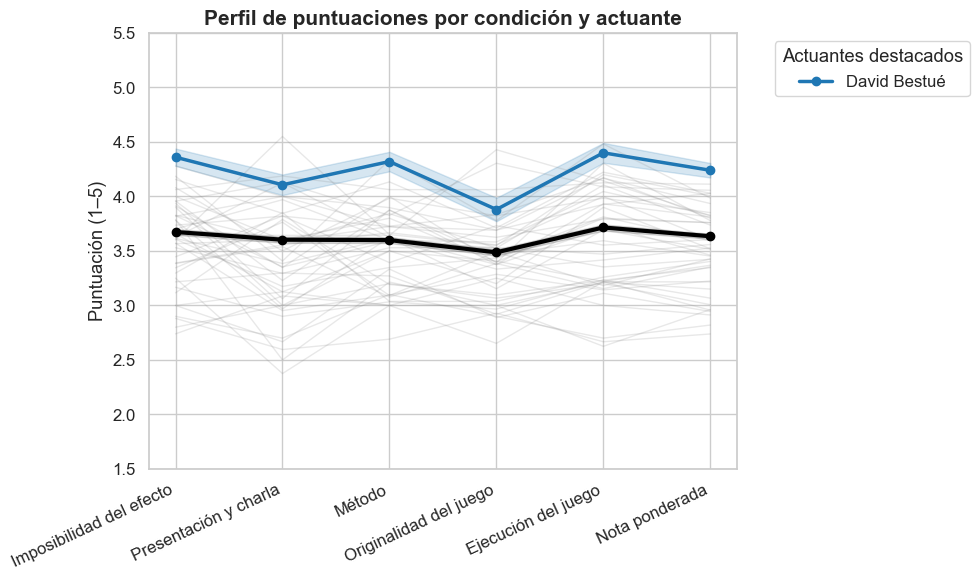

In [43]:

# --- Configuración de columnas ---
cols = [
    '¿Qué te ha parecido la imposibilidad del efecto realizado?',
    '¿Qué te han parecido la presentación y la charla?',
    '¿Qué te ha parecido el método?',
    '¿Qué te ha parecido la originalidad del juego?',
    '¿Qué te ha parecido la ejecución del juego?',
    'nota'
]

nombres_cond = [
    'Imposibilidad del efecto',
    'Presentación y charla',
    'Método',
    'Originalidad del juego',
    'Ejecución del juego',
    'Nota ponderada'
]

# --- lista de actuantes a destacar ---
destacados = ["David Bestué"]  # edítala libremente

# --- preparar datos numéricos ---
df_num = df.copy()
for c in cols:
    df_num[c] = pd.to_numeric(df_num[c], errors="coerce")

# --- función para IC95% ---
def ci95(series):
    x = series.dropna()
    n = len(x)
    if n <= 1:
        m = x.mean() if n == 1 else np.nan
        return m, np.nan, np.nan
    m = x.mean()
    h = stats.sem(x) * stats.t.ppf(0.845, n - 1)
    return m, m - h, m + h

# --- estilo ---
sns.set_theme(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(10, 6))

# --- Fondo gris: una línea por actuante (sin IC) ---
for act, sub in df_num.groupby("actuante_original"):
    # medias de cada columna (una por condición)
    medias = [sub[c].mean() for c in cols]
    plt.plot(nombres_cond, medias, color=(0.5, 0.5, 0.5, 0.18), linewidth=1)


# --- Línea negra gruesa con IC69% ---
# Media y error por condición (cols)
means = [df[c].mean() for c in cols]
stds = [df[c].std(ddof=1) for c in cols]
ns = [df[c].count() for c in cols]

# 69% CI: z ≈ 1 (aprox una desviación estándar del error de la media)
z = 1
se = np.array(stds) / np.sqrt(ns)
ci_low = np.array(means) - z * se
ci_high = np.array(means) + z * se

# Dibujar línea y banda
plt.plot(nombres_cond, means, color="black", linewidth=3, marker="o",
         markersize=6, label="Media general")
plt.fill_between(nombres_cond, ci_low, ci_high, color="black", alpha=0.15)



# --- Destacados: color + IC ---
palette = sns.color_palette("tab10", n_colors=max(1, len(destacados)))
handles, labels = [], []

for i, act in enumerate(destacados):
    sub = df_num[df_num["actuante_original"] == act]
    if sub.empty:
        print(f"⚠️ '{act}' no se encontró en actuatne_original; se omite.")
        continue

    medias, low, high = [], [], []
    for c in cols:
        m, l, h = ci95(sub[c])
        medias.append(m)
        low.append(l)
        high.append(h)

    medias = np.array(medias)
    low = np.array(low)
    high = np.array(high)

    h_line, = plt.plot(nombres_cond, medias, color=palette[i],
                       linewidth=2.5, marker="o", label=act)
    plt.fill_between(nombres_cond, low, high, color=palette[i], alpha=0.18)
    handles.append(h_line)
    labels.append(act)

# --- estética general ---
plt.title("Perfil de puntuaciones por condición y actuante", fontsize=15, weight="bold")
plt.xlabel("")
plt.ylabel("Puntuación (1–5)")
plt.ylim(1.5, 5.5)
plt.xticks(rotation=25, ha="right")

if handles:
    plt.legend(handles=handles, labels=labels, title="Actuantes destacados",
               bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [44]:
## De una actuación concreta

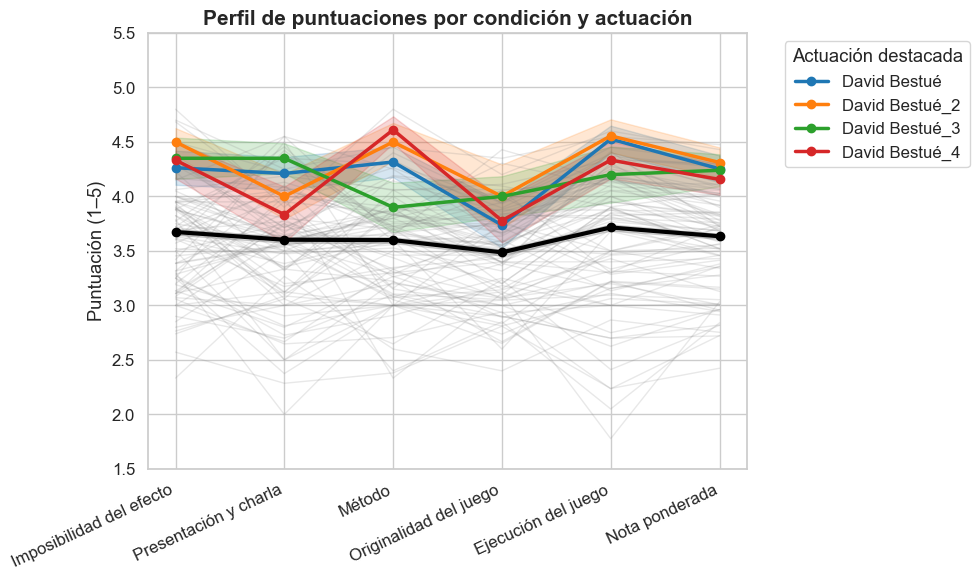

In [45]:

# --- Configuración de columnas ---
cols = [
    '¿Qué te ha parecido la imposibilidad del efecto realizado?',
    '¿Qué te han parecido la presentación y la charla?',
    '¿Qué te ha parecido el método?',
    '¿Qué te ha parecido la originalidad del juego?',
    '¿Qué te ha parecido la ejecución del juego?',
    'nota'
]

nombres_cond = [
    'Imposibilidad del efecto',
    'Presentación y charla',
    'Método',
    'Originalidad del juego',
    'Ejecución del juego',
    'Nota ponderada'
]

# --- lista de actuantes a destacar ---
destacados = ["David Bestué", "David Bestué_2", "David Bestué_3", "David Bestué_4"]  # edítala libremente

# --- preparar datos numéricos ---
df_num = df.copy()
for c in cols:
    df_num[c] = pd.to_numeric(df_num[c], errors="coerce")

# --- función para IC95% ---
def ci95(series):
    x = series.dropna()
    n = len(x)
    if n <= 1:
        m = x.mean() if n == 1 else np.nan
        return m, np.nan, np.nan
    m = x.mean()
    h = stats.sem(x) * stats.t.ppf(0.845, n - 1)  ###equivalencia al 69%
    return m, m - h, m + h

# --- estilo ---
sns.set_theme(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(10, 6))

# --- Fondo gris: una línea por actuante (sin IC) ---
for act, sub in df_num.groupby("Actuante"):
    # medias de cada columna (una por condición)
    medias = [sub[c].mean() for c in cols]
    plt.plot(nombres_cond, medias, color=(0.5, 0.5, 0.5, 0.18), linewidth=1)


# --- Línea negra gruesa con IC69% ---
# Media y error por condición (cols)
means = [df[c].mean() for c in cols]
stds = [df[c].std(ddof=1) for c in cols]
ns = [df[c].count() for c in cols]

# 69% CI: z ≈ 1 (aprox una desviación estándar del error de la media)
z = 1
se = np.array(stds) / np.sqrt(ns)
ci_low = np.array(means) - z * se
ci_high = np.array(means) + z * se

# Dibujar línea y banda
plt.plot(nombres_cond, means, color="black", linewidth=3, marker="o",
         markersize=6, label="Media general")
plt.fill_between(nombres_cond, ci_low, ci_high, color="black", alpha=0.15)



# --- Destacados: color + IC ---
palette = sns.color_palette("tab10", n_colors=max(1, len(destacados)))
handles, labels = [], []

for i, act in enumerate(destacados):
    sub = df_num[df_num["Actuante"] == act]
    if sub.empty:
        print(f"⚠️ '{act}' no se encontró en actuatne_original; se omite.")
        continue

    medias, low, high = [], [], []
    for c in cols:
        m, l, h = ci95(sub[c])
        medias.append(m)
        low.append(l)
        high.append(h)

    medias = np.array(medias)
    low = np.array(low)
    high = np.array(high)

    h_line, = plt.plot(nombres_cond, medias, color=palette[i],
                       linewidth=2.5, marker="o", label=act)
    plt.fill_between(nombres_cond, low, high, color=palette[i], alpha=0.18)
    handles.append(h_line)
    labels.append(act)

# --- estética general ---
plt.title("Perfil de puntuaciones por condición y actuación", fontsize=15, weight="bold")
plt.xlabel("")
plt.ylabel("Puntuación (1–5)")
plt.ylim(1.5, 5.5)
plt.xticks(rotation=25, ha="right")

if handles:
    plt.legend(handles=handles, labels=labels, title="Actuación destacada",
               bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Ranking

In [46]:
#De actuantes

In [47]:
# Asegurar tipo numérico
df["nota"] = pd.to_numeric(df["nota"], errors="coerce")

# Agrupar por actuante y calcular media + número de actuaciones
ranking = (
    df.groupby("actuante_original")
      .agg(
          nota_media=("nota", "mean"),
          n_actuaciones=("nota", "count")
      )
      .reset_index()
      .sort_values("nota_media", ascending=False)
      .reset_index(drop=True)
)

# Añadir posición en el ranking
ranking["posición"] = ranking.index + 1

# Reordenar columnas para legibilidad
ranking = ranking[["posición", "actuante_original", "nota_media", "n_actuaciones"]]

# Redondear medias a dos decimales
ranking["nota_media"] = ranking["nota_media"].round(2)

# Mostrar resultados
print("🏆 Ranking de actuantes por nota ponderada media:")

display(
    ranking.style
        .hide(axis="index")
        .format({
            "nota_media": "{:.2f}",
            "n_actuaciones": "{:.0f}"
        })
        .set_properties(**{"text-align": "center"})  # centrado opcional
)

🏆 Ranking de actuantes por nota ponderada media:


posición,actuante_original,nota_media,n_actuaciones
1,David Bestué,4.24,75
2,Paul H,4.11,16
3,Ivan Padín,4.06,23
4,Amílcar,4.03,45
5,Michele,4.03,68
6,Gneis,4.00,20
7,Alfredo Alvarez,3.99,27
8,Juan Martinez,3.93,66
9,Shori,3.85,62
10,Alexander Main,3.83,67


In [48]:
# De actuaciones
df["nota"] = pd.to_numeric(df["nota"], errors="coerce")

# Agrupar por actuante y calcular media + número de actuaciones
ranking = (
    df.groupby("Actuante")
      .agg(
          nota_media=("nota", "mean"),
          n_actuaciones=("nota", "count")
      )
      .reset_index()
      .sort_values("nota_media", ascending=False)
      .reset_index(drop=True)
)

# Añadir posición en el ranking
ranking["posición"] = ranking.index + 1

# Reordenar columnas para legibilidad
ranking = ranking[["posición", "Actuante", "nota_media", "n_actuaciones"]]

# Redondear medias a dos decimales
ranking["nota_media"] = ranking["nota_media"].round(2)

# Mostrar resultados
print("🏆 Ranking de actuanciones por nota ponderada media:")

display(
    ranking.style
        .hide(axis="index")
        .format({
            "nota_media": "{:.2f}",
            "n_actuaciones": "{:.0f}"
        })
        .set_properties(**{"text-align": "center"})  # centrado opcional
)

🏆 Ranking de actuanciones por nota ponderada media:


posición,Actuante,nota_media,n_actuaciones
1,Michele_3,4.47,20
2,Alfredo Alvarez_2,4.43,10
3,Amílcar_3,4.32,20
4,David Bestué_2,4.31,18
5,Alexander Main,4.30,18
6,Michele_2,4.28,19
7,Lluis Garcia_2,4.27,20
8,David Bestué,4.25,19
9,David Bestué_3,4.24,20
10,David Bestué_4,4.16,18
